In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/home/simon/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

telemetry-pure-pursuit.csv
max RPM: 16201.4648239


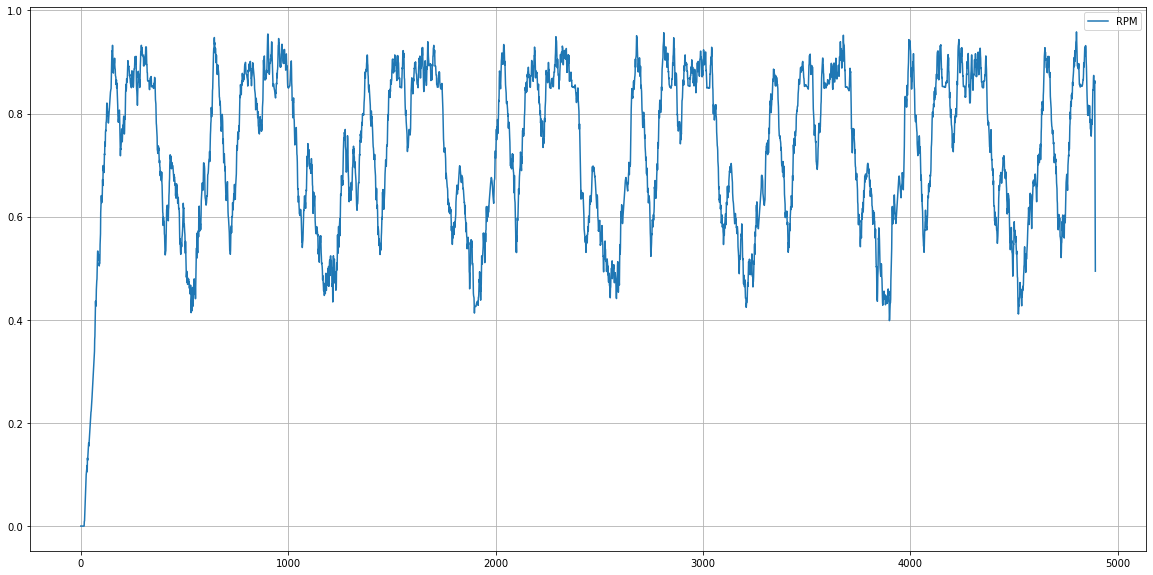

No handles with labels found to put in legend.


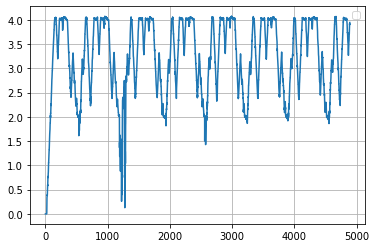

In [31]:
max_rpm = 0

input_files = ["telemetry-pure-pursuit.csv"]
csvs = []
period = 7
for file in input_files:
    print(file)
    csv = pd.read_csv(file)
    max_rpm = max(max_rpm, max(csv["motor_rpm"]))
    csv["motor_rpm"] = np.convolve(csv["motor_rpm"], np.ones((period,)) / period, mode='same')
    csvs += [csv]
    
print("max RPM: {}".format(max_rpm))
    
for csv in csvs:    
    plt.figure(figsize=(20, 10))
    plt.grid()
    #plt.plot(csv["throttle_input"], label="throttle")
    #plt.plot(csv["steering_angle_input"], label="steering angle")
    plt.plot(csv["motor_rpm"] / max_rpm, label="RPM")
    plt.legend()
    plt.show()
    
    plt.grid()
    #plt.plot(csv["throttle_input"], label="throttle")
    #plt.plot(csv["steering_angle_input"], label="steering angle")
    plt.plot(csv["speed"])
    plt.legend()
    plt.show()

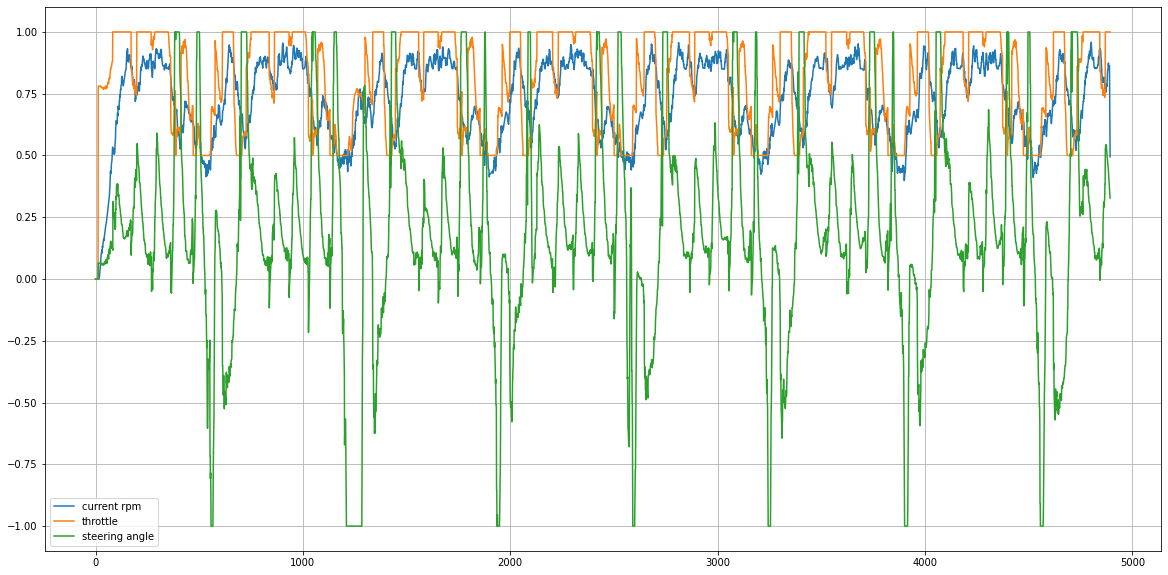

In [32]:
# I want the intput to be in the form of:
# (current RPM, throttle input, steering input, RPM change rate)

import numpy as np

data = np.array(np.zeros(4))

for csv in csvs:
    previous_rpm = 0
    for index, row in csv.iterrows():
        next_rpm = row["motor_rpm"] / max_rpm       
        previous_rpm = next_rpm
        
        record = [previous_rpm, row["throttle_input"], row["steering_angle_input"], next_rpm]
        
        data = np.vstack((data, record))

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data[:, 0], label="current rpm")
plt.plot(data[:, 1], label="throttle")
plt.plot(data[:, 2], label="steering angle")
plt.legend()
plt.show()

In [5]:
# np.random.shuffle(data)

training_portion = 0.8
split_point = int(len(data)*training_portion)
train = data[:split_point,:]
test = data[split_point:,:]

x_test = test[:, :-1]
y_test = test[:, -1]

x_train = train[:, :-1]
y_train = train[:, -1]

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(len(x_test[0]), activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_squared_error'])

model.fit(x_train, y_train, epochs=5000, use_multiprocessing=True)

# model.evaluate(x_test, y_test)

In [77]:
predicted_rpm = []
rpm = 0

for row in x_test[:500]:
    rpm = float(model.predict([[(rpm, row[1], row[2])]])[0][0])
    predicted_rpm += [rpm]

NameError: name 'lt' is not defined

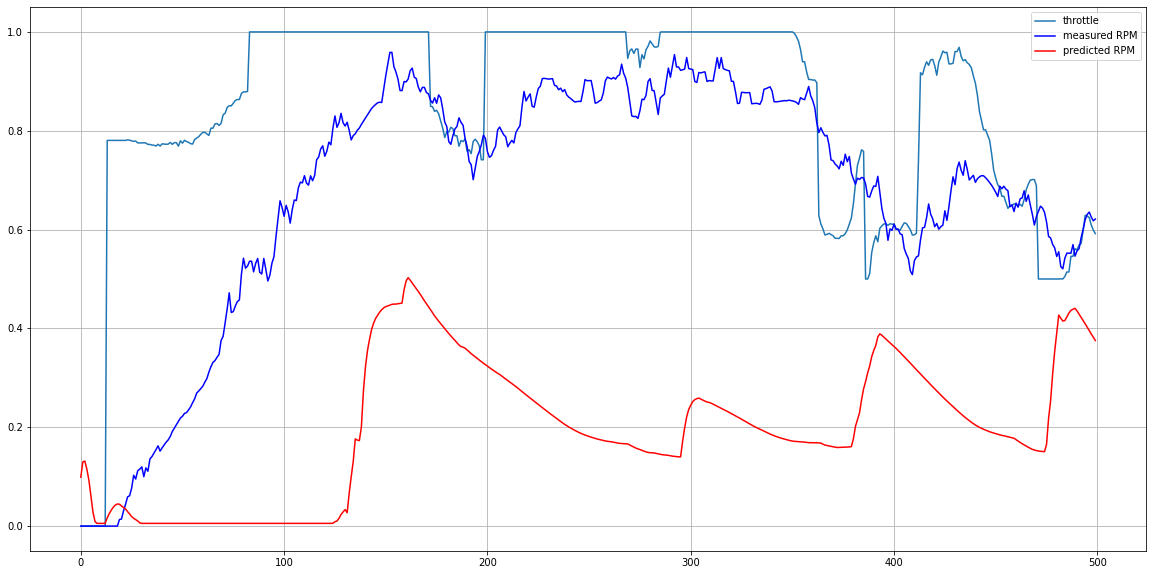

In [78]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data[:len(predicted_rpm), 1], label="throttle")
#plt.plot(data[:1000, 1], label="steering angle")
plt.plot(data[:len(predicted_rpm), 0], 'b', label="measured RPM")
plt.plot(predicted_rpm, 'r', label="predicted RPM")
plt.legend()
plt.show()

In [33]:
import neat
import random

def predict(net, offset, n):
    rpm = data[offset, 0]
    for row in data[offset:(offset + n)]:
        x = (rpm, row[1], row[2])
        y = net.activate(x)
        rpm = y[0]
        yield rpm

def activate_for(net, offset, n):
    for row in data[offset:(offset + n)]:
        yield net.activate((row[0], row[1], row[2]))[0]
        
def calculate_error(net, offset, n):
    error_sq = 0
    prediction = activate_for(net, offset, n)
    ref = data[offset:(offset + n), 3]
    for (rpm, target_rpm) in zip(prediction, ref):
        error_sq += (rpm - target_rpm) ** 2
        
    return error_sq

def eval_genomes(genomes, config):
    n = 100
    k = 5
    for genome_id, genome in genomes:
        genome.fitness = k * n
            
    for i in range(k):
        offset = random.randint(0, len(data) - n)
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            err = calculate_error(net, offset, n)
            genome.fitness -= err

In [34]:
config_file = "./evolution-config.ini"
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to N generations.
N = 10
evaluator = neat.parallel.ParallelEvaluator(32, eval_genomes)
winner = p.run(eval_genomes, N)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

# visualize.draw_net(config, winner, True, node_names=node_names)
# visualize.plot_stats(stats, ylog=False, view=True)
# visualize.plot_species(stats, view=True)


	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_connection = full_nodirect;
	if not, set initial_connection = full_direct
	if this is desired, set initial_conn


 ****** Running generation 0 ****** 

Population's average fitness: 363.90590 stdev: 104.41157
Best fitness: 493.17051 - size: (4, 12) - species 282 - id 282
Average adjusted fitness: 0.512
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     2    302.3    0.279     0
     2    0     2    482.4    0.959     0
     3    0     2    465.7    0.896     0
     4    0     2    488.9    0.984     0
     5    0     2    456.2    0.860     0
     6    0     2    454.2    0.853     0
     7    0     2    454.1    0.852     0
     8    0     2    246.9    0.070     0
     9    0     2    253.4    0.095     0
    10    0     2    460.3    0.876     0
    11    0     2    228.3    0.000     0
    12    0     2    479.9    0.950     0
    13    0     2    461.2    0.879     0
    14    0     2    402.0    0.656     0
    15    0     2    453.9    0.852     

Population's average fitness: 359.15765 stdev: 109.75061
Best fitness: 492.97416 - size: (4, 11) - species 448 - id 611
Average adjusted fitness: 0.515
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1     2    298.6    0.164     1
     2    1     2    478.8    0.945     1
     3    1     2    469.8    0.910     0
     4    1     2    486.3    0.938     1
     5    1     2    457.3    0.867     0
     6    1     2    459.8    0.872     0
     7    1     2    455.4    0.482     0
     8    1     2    312.4    0.207     0
     9    1     2    243.4    0.094     1
    10    1     2    461.5    0.879     0
    11    1     2    217.1    0.000     1
    12    1     2    475.4    0.854     1
    13    1     2    463.5    0.878     0
    14    1     2    386.5    0.338     1
    15    1     2    455.2    0.863     0
    16    1     2    217.7    0.001  

Population's average fitness: 345.54353 stdev: 139.03605
Best fitness: 496.21501 - size: (4, 11) - species 448 - id 611
Average adjusted fitness: 0.537
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    2     2    269.2    0.161     2
     2    2     2    481.0    0.932     2
     3    2     2    482.5    0.951     0
     4    2     2    491.6    0.973     0
     5    2     2    476.1    0.938     0
     6    2     2    478.7    0.942     0
     7    2     2    476.2    0.488     0
     8    2     2    275.8    0.194     1
     9    2     2    203.0    0.098     2
    10    2     2    471.8    0.916     0
    11    2     2    170.6    0.000     2
    12    2     2    468.3    0.860     2
    13    2     2    476.8    0.939     0
    14    2     2    367.1    0.325     2
    15    2     2    475.9    0.938     0
    16    2     2    171.1    0.001  

Population's average fitness: 337.78242 stdev: 129.30794
Best fitness: 496.96784 - size: (4, 11) - species 23 - id 984
Average adjusted fitness: 0.530
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    3     2    273.6    0.204     3
     2    3     2    474.5    0.910     3
     3    3     2    461.6    0.890     1
     4    3     2    479.9    0.922     1
     5    3     2    454.1    0.873     1
     6    3     2    456.1    0.877     1
     7    3     2    454.3    0.472     1
     8    3     2    253.4    0.193     2
     9    3     2    209.2    0.147     3
    10    3     2    462.2    0.891     1
    11    3     2    176.2    0.053     3
    12    3     2    458.0    0.866     3
    13    3     2    454.0    0.873     1
    14    3     2    344.0    0.318     3
    15    3     2    454.0    0.873     1
    16    3     2    176.8    0.054   

Population's average fitness: 382.78025 stdev: 71.70171
Best fitness: 495.03192 - size: (4, 12) - species 148 - id 148
Average adjusted fitness: 0.460
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4     2    338.0    0.130     0
     2    4     2    493.3    0.977     0
     3    4     2    448.2    0.768     2
     4    4     2    491.2    0.873     2
     5    4     2    433.5    0.696     2
     6    4     2    437.4    0.707     2
     7    4     2    430.5    0.449     2
     8    4     2    377.9    0.260     0
     9    4     2    308.0    0.091     0
    10    4     2    457.9    0.812     2
    11    4     2    287.3    0.000     0
    12    4     2    490.7    0.849     0
    13    4     2    441.7    0.716     2
    14    4     2    439.7    0.393     0
    15    4     2    430.3    0.689     2
    16    4     2    287.8    0.001   

Population's average fitness: 356.95139 stdev: 119.89742
Best fitness: 495.02335 - size: (4, 11) - species 448 - id 611
Average adjusted fitness: 0.525
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    5     2    282.5    0.139     1
     2    5     2    481.7    0.935     1
     3    5     2    474.6    0.923     3
     4    5     2    493.2    0.962     0
     5    5     2    465.2    0.896     3
     6    5     2    468.7    0.902     3
     7    5     2    464.6    0.488     3
     8    5     2    282.8    0.158     1
     9    5     2    232.3    0.095     1
    10    5     2    466.4    0.898     3
    11    5     2    204.5    0.000     1
    12    5     2    476.1    0.871     1
    13    5     2    468.1    0.901     3
    14    5     2    364.8    0.293     1
    15    5     2    464.3    0.894     3
    16    5     2    205.1    0.001  

Population's average fitness: 354.47653 stdev: 119.38905
Best fitness: 493.62397 - size: (4, 11) - species 448 - id 611
Average adjusted fitness: 0.525
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    6     2    293.0    0.176     2
     2    6     2    478.5    0.944     2
     3    6     2    470.8    0.919     4
     4    6     2    485.1    0.948     1
     5    6     2    465.0    0.898     4
     6    6     2    466.0    0.900     4
     7    6     2    462.7    0.486     4
     8    6     2    314.0    0.236     2
     9    6     2    228.9    0.096     2
    10    6     2    464.2    0.888     4
    11    6     2    200.7    0.000     2
    12    6     2    473.1    0.850     2
    13    6     2    468.4    0.904     4
    14    6     2    392.0    0.363     2
    15    6     2    462.5    0.894     4
    16    6     2    201.3    0.001  

Population's average fitness: 356.52796 stdev: 110.91329
Best fitness: 491.79562 - size: (4, 11) - species 448 - id 611
Average adjusted fitness: 0.512
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    7     2    296.4    0.160     3
     2    7     2    472.4    0.924     3
     3    7     2    464.1    0.897     5
     4    7     2    488.5    0.943     2
     5    7     2    455.0    0.864     5
     6    7     2    457.6    0.869     5
     7    7     2    453.5    0.482     5
     8    7     2    296.6    0.180     3
     9    7     2    241.0    0.095     3
    10    7     2    468.5    0.913     5
    11    7     2    214.5    0.000     3
    12    7     2    472.8    0.870     3
    13    7     2    459.0    0.872     5
    14    7     2    369.2    0.304     3
    15    7     2    453.3    0.861     5
    16    7     2    215.0    0.001  

Population's average fitness: 384.84615 stdev: 57.83712
Best fitness: 494.10776 - size: (4, 12) - species 148 - id 148
Average adjusted fitness: 0.419
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    8     2    361.2    0.173     0
     2    8     2    493.3    0.942     4
     3    8     2    449.6    0.712     6
     4    8     2    481.8    0.797     3
     5    8     2    418.2    0.586     6
     6    8     2    420.8    0.594     6
     7    8     2    414.4    0.416     6
     8    8     2    414.8    0.354     0
     9    8     2    325.5    0.094     0
    10    8     2    457.6    0.793     6
    11    8     2    306.2    0.000     0
    12    8     2    487.5    0.826     4
    13    8     2    428.7    0.614     6
    14    8     2    452.0    0.449     0
    15    8     2    414.2    0.575     6
    16    8     2    306.7    0.002   

Population's average fitness: 369.33769 stdev: 87.43974
Best fitness: 489.73995 - size: (4, 11) - species 448 - id 611
Average adjusted fitness: 0.493
Mean genetic distance 3.515, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    9     2    339.8    0.236     1
     2    9     2    486.0    0.946     5
     3    9     2    460.5    0.850     7
     4    9     2    468.0    0.871     4
     5    9     2    441.1    0.791     7
     6    9     2    443.1    0.796     7
     7    9     2    439.4    0.459     7
     8    9     2    362.1    0.290     1
     9    9     2    276.7    0.101     1
    10    9     2    465.3    0.887     7
    11    9     2    252.4    0.000     1
    12    9     2    480.7    0.846     5
    13    9     2    444.5    0.798     7
    14    9     2    412.4    0.418     1
    15    9     2    439.2    0.787     7
    16    9     2    253.1    0.002   

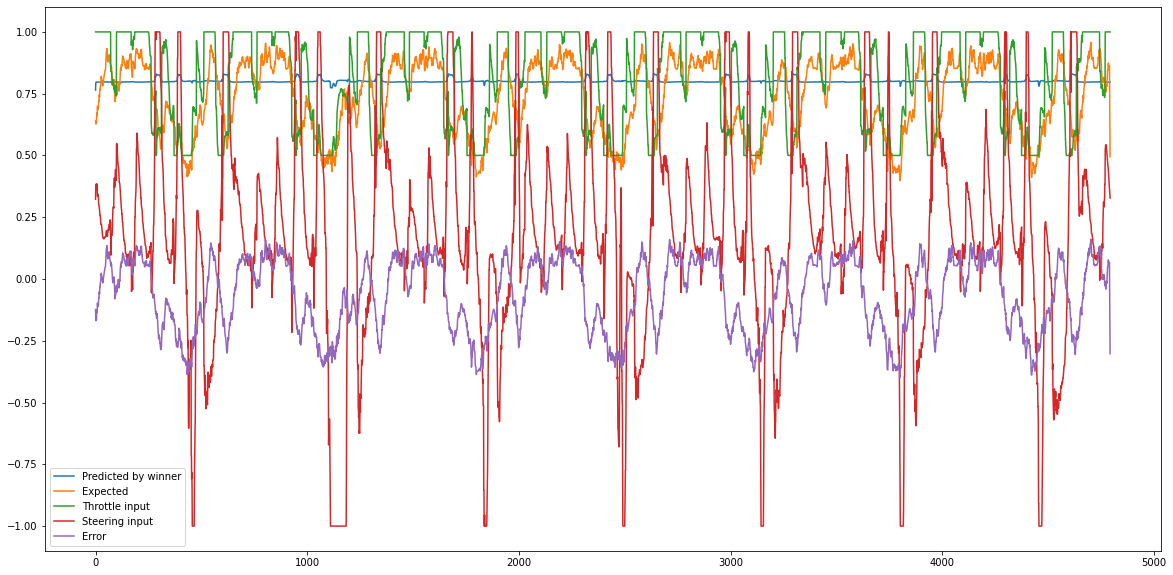

In [36]:
o = 100
l = 5000
predicted = list(predict(winner_net, o, l))
plt.figure(figsize=(20, 10))
plt.plot(predicted, label="Predicted by winner")
plt.plot(data[o:(o+l),3], label="Expected")
plt.plot(data[o:(o+l),1], label="Throttle input")
plt.plot(data[o:(o+l),2], label="Steering input")
plt.plot(data[o:(o+l),3] - predicted, label="Error")
plt.legend()
plt.show()

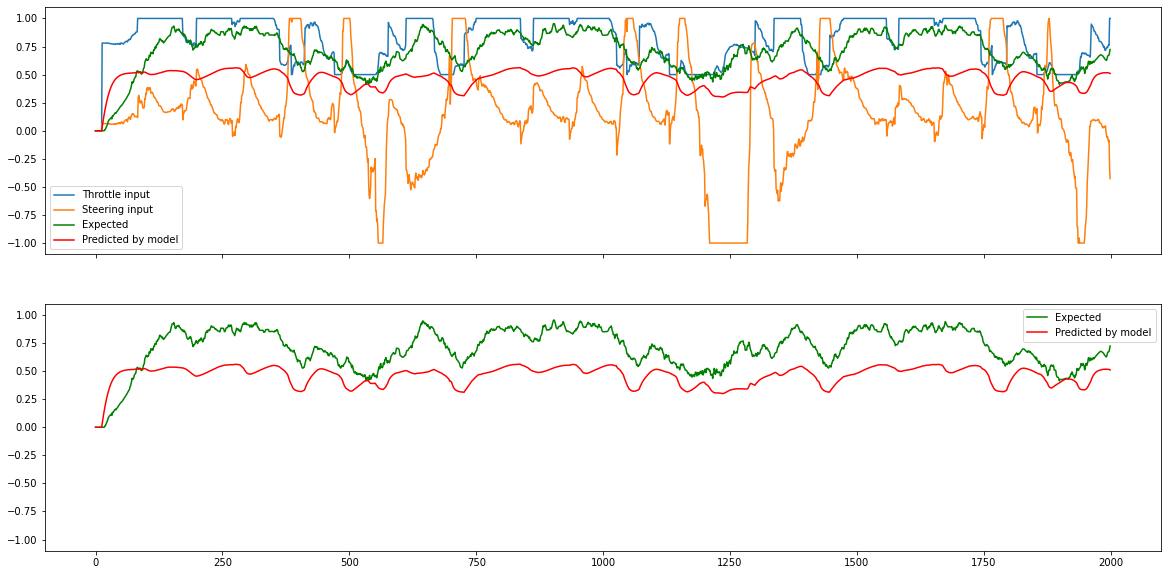

In [37]:
import math
max_rpm_normalized = 1.0

def torque(rpm, stall_torque):
    return stall_torque - (stall_torque / max_rpm_normalized) * rpm

def predict_torque(rpm, throttle, steering, x):
    drive_torque = torque(rpm, x[0]) * throttle
    load_torque = (rpm ** x[2]) * ((x[3] + x[4] * abs(steering)) ** x[5])

    return (drive_torque - load_torque) / x[1]

dt = 1./25.
steering_adjustment_step = 6.25 * dt
        
def predict_custom(offset, n, x):
    rpm = float(data[offset, 0])
    for row in data[offset:(offset + n)]:   
        motor_rpm_acc = predict_torque(rpm, row[1], row[2], x)        
        rpm = max(0, rpm + motor_rpm_acc * dt)
        yield rpm
        
o = 0
l = 2000
x = [800.0, 800.0, 2, 10.0, 5.0, 3.0]
predicted = np.array(list(predict_custom(o, l, x)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g', label="Expected")
ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g', label="Expected")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()
plt.show()


In [49]:
from scipy.optimize import minimize

def err(x):
    err = 0
    offset = 0
    for csv in csvs:
        predicted = predict_custom(offset, len(csv), x)
        offset += len(csv)
        for (pred, ref) in zip(predicted, data):
            err += (pred - ref[3]) ** 2
        return err

x0 = [ 1.04431894,  3.61423249, 11.04262114,  0.94666014,  0.14904717, 63.33798472]
bnds = ((0, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000))
res = minimize(err, x0, method='SLSQP', bounds=bnds).x

print(res)


[7.40215594e+00 2.55265975e+01 1.10499197e+01 9.96361655e-01
 2.61725199e-02 3.48736968e+02]


[7.40215594e+00 2.55265975e+01 1.10499197e+01 9.96361655e-01
 2.61725199e-02 3.48736968e+02]


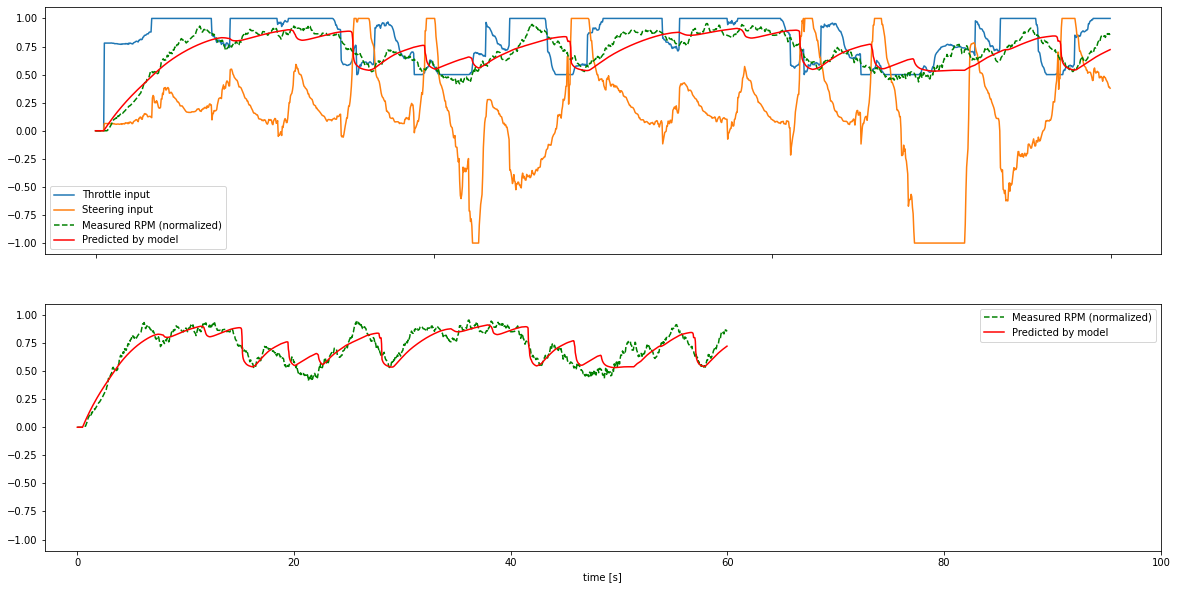

In [54]:
l = 1500
o = 0

print(res)

# for csv in csvs:
#     o += l
#     l = len(csv)
predicted = np.array(list(predict_custom(o, l, res)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()

plt.xlabel("time [s]")
plt.xticks([0, 500, 1000, 1500, 2000, 2500], [0, 20, 40, 60, 80, 100])

plt.show()
# plt.savefig("fit_{}.pdf".format(o));